In [ ]:
Давайте представим, что вы работаете в команде разработчиков в онлайн-бизнесе электронной коммерции среднего размера.
Дизайнер UX действительно усердно работал над новой версией страницы продукта в надежде, что это приведет
к более высокому коэффициенту конверсии. Менеджер по продукту (PM) сказал вам, что текущий коэффициент конверсии составляет около
в среднем на 13% в течение года, и что команда была бы довольна увеличением на 2%, а это означает, что
новый дизайн будет считаться успешным, если он повысит коэффициент конверсии до 15%.

In [57]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from math import ceil
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

%matplotlib inline

# настроим визуализацию
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [37]:
df = pd.read_csv(r'source\ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [39]:
#проверка на Null
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [40]:
# Проверяем, как распределены пользователи по группам: видно, что в тестовую группу попадала старая страница,
# а в контрольную новая. Возможно есть проблемы с назначением в группы.
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [41]:
# Поскольку есть достаточное количество записей с нужными событиями в каждой из групп, то отфильтруем ненужные:
df = df.query('(group == "control" & landing_page == "old_page") | (group == "treatment" & landing_page == "new_page")')
pd.crosstab(df['group'], df['landing_page'])


landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


In [42]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [43]:
#Проверим уникальность ползователей
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'Есть {multi_users} пользователь встречающийся более одного раза')

Есть 1 пользователь встречающийся более одного раза


In [44]:
#Проверим все ли пользователи контрольной группы уникальны. Результат - все.
print(df.query('group == "control"').user_id.count(),df.query('group == "control"').user_id.nunique())

145274 145274


In [45]:
#Проверим все ли пользователи тестовой группы уникальны. Результат - один повторяется.
print(df.query('group == "treatment"').user_id.count(),df.query('group == "treatment"').user_id.nunique())

145311 145310


In [46]:
#посмотрим дубли
df.loc[df.duplicated(subset=['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [47]:
#удаляем дубликаты по пользователям.
df = df.drop_duplicates(subset=['user_id'])

In [48]:
#Убеждаемся в отсутствии дублей
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()
print(f'Есть {multi_users} пользователь встречающийся более одного раза')

Есть 0 пользователь встречающийся более одного раза


In [49]:
### Рассчитаем размер выборки

In [50]:
import statsmodels.stats.api as sms
from math import ceil
effect_size = sms.proportion_effectsize(0.13, 0.15)    

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  

required_n = ceil(required_n)     #расчёт размера выборки одной группы                                              
                        
print(required_n)               

4720


In [51]:
### Создадим выборки c требуемым размером. random_state=22 задаёт некое начальное значение для генератора "случайных чисел"

In [52]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [53]:
ab_test['group'].value_counts()

treatment    4720
control      4720
Name: group, dtype: int64

In [54]:
### results

In [55]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.120,0.325,0.005
treatment,0.118,0.322,0.005


In [33]:
# Судя по приведенной выше статистике, два наших дизайна выполнены очень похоже,
# при этом наш новый дизайн работает немного хуже: прибл. коэффициент конверсии 11,8% против 12%.

In [ ]:
### визуализируем

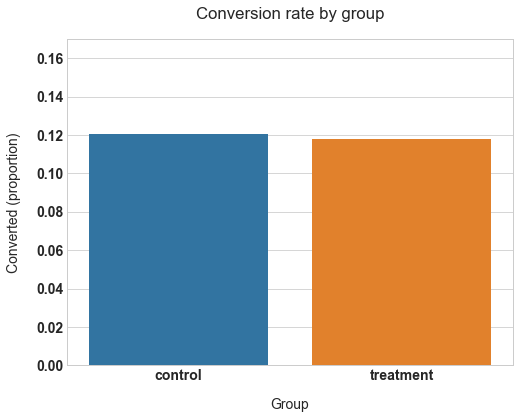

In [58]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

In [ ]:
### Проверка гипотезы

In [59]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [60]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 0.38
p-value: 0.703
ci 95% for control group: [0.111, 0.130]
ci 95% for treatment group: [0.109, 0.127]


In [ ]:
# p-value: 0.703 - выше 0.05 - отвергаем Н0

In [61]:
# Получение p-value черзе FIT - результат тот же
fit = stats.ttest_ind(ab_test[ab_test.group == 'treatment'].converted, 
                          ab_test[ab_test.group == 'control'].converted)
fit

Ttest_indResult(statistic=-0.38131525659408905, pvalue=0.7029779176525428)